In [ ]:
! wget https://raw.githubusercontent.com/golnaz76gh/pars-offensive-dataset/refs/heads/main/ParsOffensive.xlsx
! pip install openpyxl hazm skl2onnx huggingface_hub

# Import needed Libraries

In [62]:
import numpy as np
import pandas as pd
from hazm import Lemmatizer, Normalizer, word_tokenizer, stopwords_list
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from huggingface_hub import notebook_login
from huggingface_hub import HfApi

RANDOM_SEED = 42

# Read Data

In [33]:
df = pd.read_excel("./ParsOffensive.xlsx", engine='openpyxl')
df.sample(2) # Sorry i cannot show too much samples

,comment,label
1426,چقد حال بهم زنه,Neutral
4113,عرعر ببر تو خونه خودت برای بچه های خودتون پدرس...,Offensive


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8433 entries, 0 to 8432
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  8432 non-null   object
 1   label    8433 non-null   object
dtypes: object(2)
memory usage: 131.9+ KB


We have 8433 rows, each row label can be `Offensive` or `Neutral`.

<Axes: >

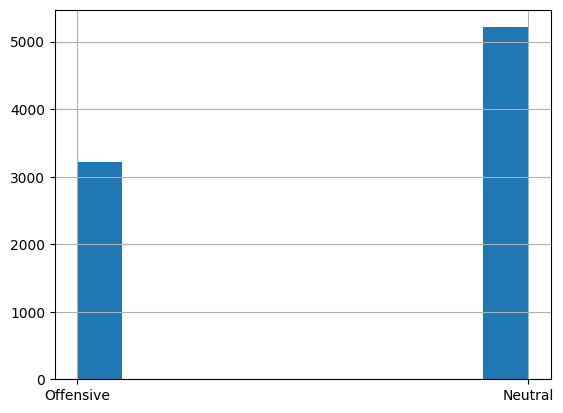

In [35]:
df['label'].hist()

We have old imbalanced data challenge here.

In [36]:
df.isna().sum()

,0
comment,1
label,0


In [37]:
df = df.dropna()

In [38]:
df.isna().sum()

,0
comment,0
label,0


We had only 1 NaN comment, I removed it.

In [39]:
largest = 0
idx = 0
for i in range(len(df)):
    if largest < len(df.iloc[i].comment):
        largest = len(df.iloc[i].comment)
        idx = i

print(f"largets comment length in dataset is {largest} in index {idx}")

largets comment length in dataset is 787 in index 1297


In [40]:
df.iloc[1297]

,1297
comment,امثال تو این نوع فیلم‌ها رو ببینن سکته میکنن ،...
label,Neutral


# Preprocess

## Setup clean text function

In [41]:
stopwords = stopwords_list()
lemmatizer = Lemmatizer()
normalizer = Normalizer()
labelEncoder = LabelEncoder()

We need a function for cleaning our comments

In [42]:
def clean_sentences(sentence: str) -> str:
    return " ".join(lemmatizer.lemmatize(word) for word in normalizer.normalize(sentence).split(" ") if word not in stopwords)

In [43]:
df['comment'] = df['comment'].map(clean_sentences)

## Label encode target

We also need to encode our labels

In [44]:
df['label'] = labelEncoder.fit_transform(df['label'])

## Split data

Now time for split our data in train and test

In [45]:
X = df.comment
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## Vectorize text

In [46]:
tfidfVec = TfidfVectorizer()
X_train_tfidf = tfidfVec.fit_transform(X_train)
X_test_tfidf = tfidfVec.transform(X_test)

## Handel imbalance data using ADASYN

In [47]:
adasyn = ADASYN(random_state=RANDOM_SEED, n_neighbors=5)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train_tfidf, y_train)

<Axes: >

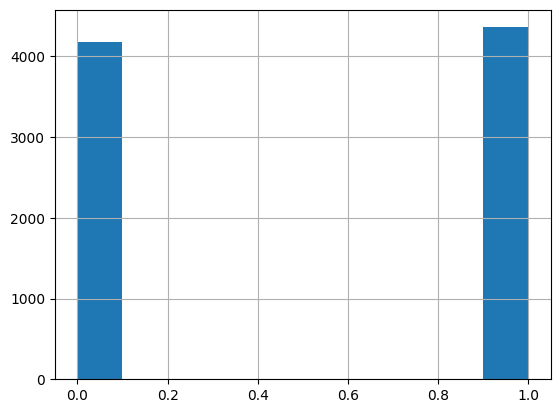

In [48]:
y_adasyn.hist()

# Model design

I need an evaluation function

In [49]:
def evaluateModel(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {
        "accuracy": acc,
        "precision": prec,
        "recall":recall,
        "f1_score": f1
    }


In [50]:
def KFoldCrossValidation(model, X, y, k=5):
    X_data = tfidfVec.transform(X)

    kf = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)
    scores = cross_val_score(model, X_data, y, cv=kf, scoring='accuracy')
    print(f"accuracy for each fold: {scores}")
    average_accuracy = np.mean(scores)
    print(f"mean Accuracy: {average_accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.81      0.96      0.87      1043
           1       0.90      0.63      0.74       644

    accuracy                           0.83      1687
   macro avg       0.85      0.79      0.81      1687
weighted avg       0.84      0.83      0.82      1687

{'accuracy': 0.8298755186721992, 'precision': 0.8975501113585747, 'recall': 0.6257763975155279, 'f1_score': 0.737419945105215}
accuracy for each fold: [0.83046829 0.82335507 0.82680902 0.84223013 0.83570581]
mean Accuracy: 0.83


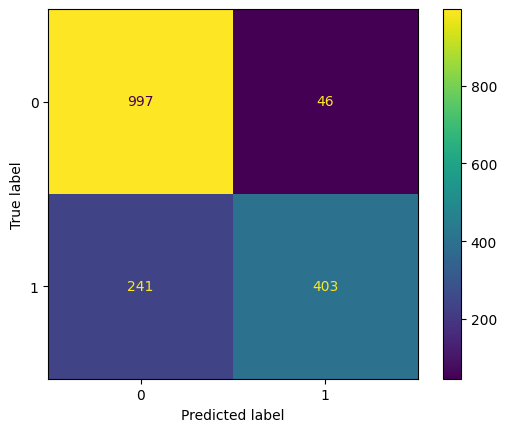

In [51]:
model_svm = SVC(random_state=RANDOM_SEED)
model_svm.fit(X_adasyn, y_adasyn)

print(evaluateModel(model_svm, X_test_tfidf, y_test))
KFoldCrossValidation(model_svm, X, y, 5)

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1043
           1       0.70      0.74      0.72       644

    accuracy                           0.78      1687
   macro avg       0.77      0.77      0.77      1687
weighted avg       0.78      0.78      0.78      1687

{'accuracy': 0.7818612922347362, 'precision': 0.7023460410557185, 'recall': 0.7437888198757764, 'f1_score': 0.722473604826546}


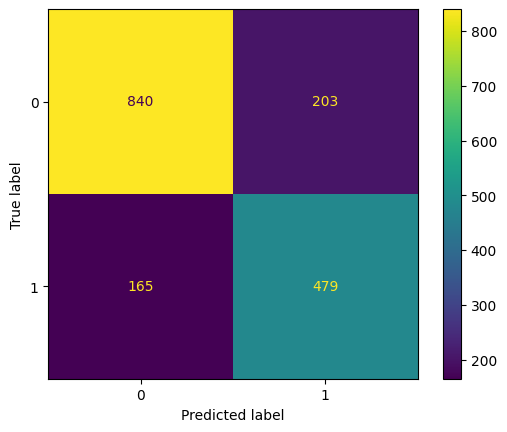

In [52]:
model_rfc = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=150)
model_rfc.fit(X_adasyn, y_adasyn)

print(evaluateModel(model_rfc, X_test_tfidf, y_test))
# KFoldCrossValidation(model_rfc, X, y, 5) # this one takes to long!

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1043
           1       0.73      0.78      0.75       644

    accuracy                           0.81      1687
   macro avg       0.79      0.80      0.80      1687
weighted avg       0.81      0.81      0.81      1687

{'accuracy': 0.8055720213396562, 'precision': 0.7276657060518732, 'recall': 0.7841614906832298, 'f1_score': 0.7548579970104634}
accuracy for each fold: [0.8114997  0.81090694 0.8113879  0.82206406 0.82562278]
mean Accuracy: 0.82


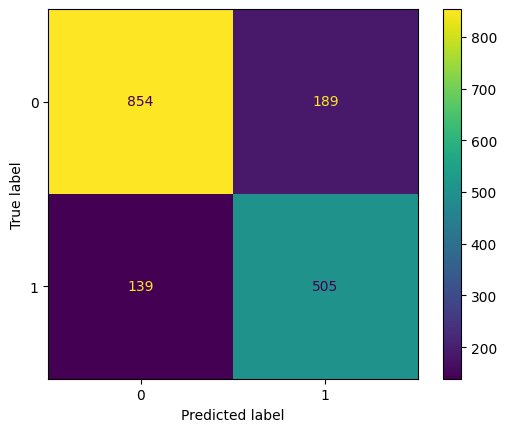

In [53]:
model_lr = LogisticRegression(random_state=RANDOM_SEED)
model_lr.fit(X_adasyn, y_adasyn)

print(evaluateModel(model_lr, X_test_tfidf, y_test))
KFoldCrossValidation(model_lr, X, y, 5)

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1043
           1       0.74      0.82      0.78       644

    accuracy                           0.82      1687
   macro avg       0.81      0.82      0.82      1687
weighted avg       0.83      0.82      0.82      1687

{'accuracy': 0.8227622999407231, 'precision': 0.743988684582744, 'recall': 0.8167701863354038, 'f1_score': 0.7786824574389342}
accuracy for each fold: [0.81446354 0.81920569 0.82087782 0.81020166 0.82799526]
mean Accuracy: 0.82


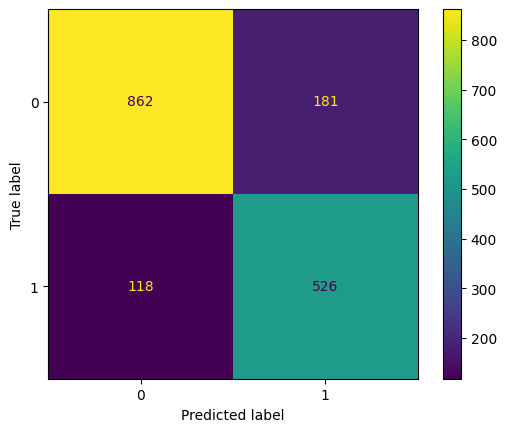

In [54]:
np.random.seed(RANDOM_SEED)

model_nb = MultinomialNB()
model_nb.fit(X_adasyn, y_adasyn)

print(evaluateModel(model_nb, X_test_tfidf, y_test))
KFoldCrossValidation(model_nb, X, y, 5)


## Pipeline design with best model

In [55]:
model_pipline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('classifier', SVC(random_state=RANDOM_SEED, probability=True))
    ]
)

In [56]:
model_pipline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


              precision    recall  f1-score   support

           0       0.80      0.96      0.88      1043
           1       0.91      0.62      0.74       644

    accuracy                           0.83      1687
   macro avg       0.86      0.79      0.81      1687
weighted avg       0.84      0.83      0.82      1687



{'accuracy': 0.8304682868998222,
 'precision': 0.908675799086758,
 'recall': 0.6180124223602484,
 'f1_score': 0.7356746765249538}

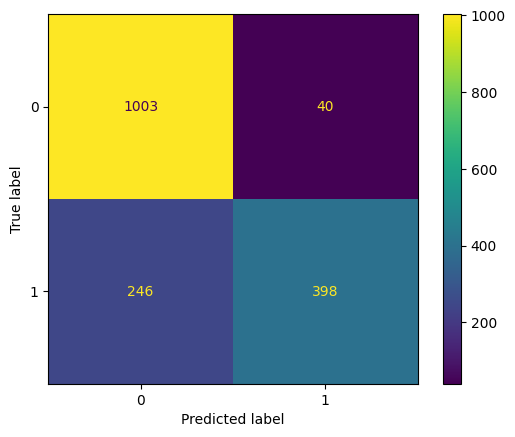

In [57]:
evaluateModel(model_pipline, X_test, y_test)

In [91]:
sample_texts = ["کثافت", "کار شما خیلی اشتباه است", "احمق بیسواد!"]

for text in sample_texts:
    print(f"text: {text}")
    print(f"probability: {list(model_pipline.predict_proba([clean_sentences(text)]))}")
    print(f"prediction: {list(model_pipline.predict([clean_sentences(text)]))}")
    print()

text: کثافت
probability: [array([0.00377584, 0.99622416])]
prediction: [np.int64(1)]

text: کار شما خیلی اشتباه است
probability: [array([0.92034815, 0.07965185])]
prediction: [np.int64(0)]

text: احمق بیسواد!
probability: [array([0.00861761, 0.99138239])]
prediction: [np.int64(1)]



# Save model with ONNX

In [60]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

# define input type as an array of strings
initial_type = [('input', StringTensorType([None, 1]))]

# convert sklearn to onnx
onx = convert_sklearn(model_pipline, initial_types=initial_type)

# save it
MODEL_NAME = "offensive_text_classifier"
with open(f"{MODEL_NAME}.onnx", "wb") as f:
    f.write(onx.SerializeToString())

print(f"model saved as `{MODEL_NAME}.onnx` With no error")

model saved as `offensive_text_classifier.onnx` With no error


# upload model to HF

In [ ]:
REPO_ID = "sirunchained/bad-comment"

hf_api = HfApi()

# Upload the ONNX model file
hf_api.upload_file(
    path_or_fileobj=f"{MODEL_NAME}.onnx",
    path_in_repo=f"{MODEL_NAME}.onnx",
    repo_id=REPO_ID,
)

print(f"Model '{MODEL_NAME}.onnx' uploaded to https://huggingface.co/{REPO_ID}")